In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pims
import pickle
from skimage.measure import regionprops
from pathlib import Path
from gzip import GzipFile

## Cell Tensors


In [72]:
cell_data = pd.read_csv('rcnnPD1pos_by_TYRP1UNcomp_PD1UNcomp.txt')
cell_data = cell_data.rename(
    columns = {"X1": "segmentation_ix", "Tile Row": "tile_y", "Tile Col": "tile_x", "Tile Z": "tile_z", "In-Tile Y": "cell_tile_y", "In-Tile X": "cell_tile_x"}
)

In [73]:
cell_data.head()

,segmentation_ix,Reg,tile_y,tile_x,tile_z,cell_tile_y,cell_tile_x,Absolute Y,Absolute X,Cell Size,...,segf233_UNcomp,segf234_UNcomp,segf241_UNcomp,segf242_UNcomp,segf243_UNcomp,segf244_UNcomp,segf251_UNcomp,segf252_UNcomp,segf253_UNcomp,segf254_UNcomp
0,80,5,1,1,11,701.324324,261.054054,701,261,186,...,3468.032258,3468.032258,11783.215054,11783.215054,12866.064516,12866.064516,6182.258065,6182.258065,7117.930108,7117.930108
1,212,5,1,1,11,716.507692,264.353846,717,264,140,...,1584.450000,1584.450000,12921.900000,12921.900000,11500.878571,11500.878571,6286.750000,6286.750000,3635.735714,3635.735714
2,219,5,1,1,11,705.239583,276.666667,705,277,223,...,2402.470852,2402.470852,13242.367713,13242.367713,12989.067265,12989.067265,6563.331839,6563.331839,4254.322870,4254.322870
3,122,5,2,1,10,13.150538,283.225806,733,283,189,...,7170.661376,7170.661376,12770.460317,12770.460317,15337.449735,15337.449735,5986.857143,5986.857143,13440.227513,13440.227513
4,128,5,2,1,10,32.719298,135.298246,753,135,154,...,1584.824675,1584.824675,11859.629870,11859.629870,11903.779221,11903.779221,5830.935065,5830.935065,3637.285714,3637.285714


In [26]:
test = next(iter(cell_data.itertuples()))

In [170]:
save_dir = Path('/home/idies/workspace/Storage/bmyury/shared_scripts_and_files/rcnn_cell_tensors')
save_dir.mkdir(exist_ok=True)

channelNames = list(pd.read_csv('channelNames.txt', header = None)[0].values)

In [171]:
len(channelNames)

100

In [172]:
def get_segmentation_mask(
    tile_x, tile_y, tile_z, pattern='reg005_X{x:02d}_Y{y:02d}_Z{z:02d}visual_growth3labeled_mask.tif', directory='reg5_Graham_masks'
):
    img = pims.TiffStack(Path(directory) / pattern.format(x=tile_x, y=tile_y, z=tile_z))
    return np.array(img)[0, ...]

In [47]:
%pdb

Automatic pdb calling has been turned ON


In [174]:
def make_cell_stack(
    cell_data, channelNames, markers,
    mask_cells=True, box_size=32, tile_path=Path('reg5_best_focal_plane'),
    tile_pattern='reg005_X{x:02d}_Y{y:02d}_Z{z:02d}.tif'
):
    cell_data["cell_idx"] = np.arange(cell_data.shape[0])
    cell_stack = np.empty((cell_data.shape[0], len(markers), box_size, box_size), dtype=np.uint16)
    skipped_cells = []
    cd_grouped = cell_data.groupby(["tile_x", "tile_y", "tile_z"])
    for (tx, ty, z), cd in cd_grouped:
        print((tx, ty, z))
        tn = tile_pattern.format(x=tx, y=ty, z=z)
        img = np.array(pims.TiffStack(tile_path / tn))
        img = np.pad(img, ((0, 0), (box_size, box_size), (box_size, box_size)))
        if mask_cells:
            segmentation_mask = get_segmentation_mask(tx, ty, z)
            segmentation_mask = np.pad(segmentation_mask, box_size)
        for c in cd.itertuples():
            cx = int(c.cell_tile_x) + box_size
            cy = int(c.cell_tile_y) + box_size
            cell_box = (
                (cy - box_size//2, cy + box_size//2),
                (cx - box_size//2, cx + box_size//2)
            )
            ci = img[
                :,
                cell_box[0][0]:cell_box[0][1],
                cell_box[1][0]:cell_box[1][1]
            ]
            if mask_cells:
                mask = segmentation_mask[
                    cell_box[0][0]:cell_box[0][1],
                    cell_box[1][0]:cell_box[1][1]
                ]
                ci = ci.copy()
                ci[:, mask != c.segmentation_ix] = 0
            cell_stack[c.cell_idx, :, :, :] = ci
    return cell_stack

In [182]:
cell_stack = make_cell_stack(cell_data, channelNames, channelNames, mask_cells=True)

(1, 1, 11)
(1, 2, 10)
(1, 3, 10)
(1, 7, 10)
(1, 8, 9)
(1, 9, 9)
(2, 3, 10)
(2, 7, 10)
(2, 8, 9)
(2, 9, 9)
(3, 1, 10)
(3, 2, 9)
(3, 3, 9)
(3, 4, 8)
(3, 5, 10)
(3, 6, 10)
(3, 7, 10)
(3, 8, 8)
(3, 9, 8)
(4, 1, 10)
(4, 2, 8)
(4, 4, 8)
(4, 5, 9)
(4, 6, 10)
(4, 7, 10)
(4, 8, 7)
(4, 9, 8)
(5, 1, 9)
(5, 2, 8)
(5, 3, 7)
(5, 4, 8)
(5, 5, 8)
(5, 6, 10)
(5, 7, 8)
(5, 8, 7)
(5, 9, 7)
(6, 1, 8)
(6, 2, 8)
(6, 3, 7)
(6, 4, 7)
(6, 5, 8)
(6, 6, 8)
(6, 7, 8)
(6, 8, 7)
(6, 9, 7)
(7, 1, 8)
(7, 2, 7)
(7, 3, 7)
(7, 4, 6)
(7, 5, 7)
(7, 6, 8)
(7, 7, 7)
(7, 8, 6)
(7, 9, 7)


In [183]:
print('cell_stack shape', cell_stack.shape)

cell_stack shape (3223, 100, 32, 32)


In [184]:
np.save(
    save_dir / "all_cells_markers_tensor_masked.npy",
    cell_stack
)

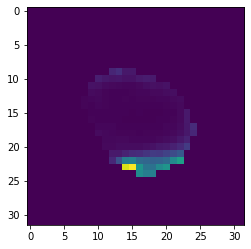

In [185]:
plt.imshow(cell_stack[0, 39, ...])